# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом  разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from lightgbm import LGBMRegressor
from datetime import datetime 

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.sample()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
331928,2016-03-12 19:00:04,2580,sedan,2001,auto,110,civic,150000,10,petrol,honda,no,2016-03-12 00:00:00,0,73441,2016-04-07 12:47:15


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [5]:
df.duplicated().sum()

4

In [6]:
df.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
NotRepaired          0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

В датасете содержится информация о 354 369  автомобилях.  
  
  Признаки:  
- DateCrawled — дата скачивания анкеты из базы  
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя.  
  
Целевой признак:  
- Price — цена (евро).  
  
В данных имеются пропуски:  
- около 20% NotRepaired, 
- примерно по 10% - в VehicleType и FuelType;
- по 5% - Gearbox и Model. 
Нужно пропуски заполнить или удалить неполные данные.

In [7]:
df['NotRepaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

Скорее всего, пропуски в NotRepaired соответствуют 'no'.

In [8]:
df['NotRepaired'] = df['NotRepaired'].fillna('no')

In [9]:
df.loc[df['NotRepaired'] == 'no', 'NotRepaired'] = False

In [10]:
df.loc[df['NotRepaired'] == 'yes', 'NotRepaired'] = True

In [11]:
df['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

Удалим пропуски в VehicleType.

In [12]:
df = df.dropna(subset=['VehicleType'])

In [13]:
df.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.000000
RegistrationYear     0.000000
Gearbox              0.031125
Power                0.000000
Model                0.040637
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.049230
Brand                0.000000
NotRepaired          0.000000
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

In [14]:
df['FuelType'].unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Если в типе двигателя есть "other", пропуски не могут обозначать альтернативную группу - удаляем.

In [15]:
df = df.dropna(subset=['FuelType'])

In [16]:
df['Model'].unique()

array([nan, 'grand', 'golf', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'twingo', 'a_klasse',
       'scirocco', '5er', 'arosa', 'civic', 'transporter', 'punto',
       'e_klasse', 'one', 'fortwo', 'clio', '1er', 'b_klasse', 'astra',
       'a8', 'jetta', 'polo', 'fiesta', 'c_klasse', 'micra', 'vito',
       'sprinter', '156', 'escort', 'forester', 'xc_reihe', 'scenic',
       'a4', 'a1', 'combo', 'focus', 'tt', 'corsa', 'a6', 'jazz', 'slk',
       '7er', '80', '147', 'meriva', 'z_reihe', 'sorento', 'v40', 'ibiza',
       'mustang', 'eos', 'touran', 'getz', 'insignia', 'a3', 'megane',
       'lupo', 'r19', 'mondeo', 'colt', 'vectra', 'berlingo', 'tiguan',
       'sharan', '6_reihe', 'c4', 'panda', 'up', 'i_reihe', 'ceed',
       'kangoo', '5_reihe', 'yeti', 'octavia', 'zafira', 'mii',
       'rx_reihe', '6er', 'fox', 'matiz', 'beetle', 'rio', 'touareg',
       'logan', 'caddy', 'omega', 'cuore', 's_max', 'modus', 'a2',
       'galaxy', 'c3'

In [17]:
len(df['Model'].unique())

251

Моделей очень много - 251, в задаче регрессии столько учесть крайне сложно. Думаю, этот признак можно вовсе удалить.неизвестную модель удаляем.

In [21]:
df = df.dropna(subset=['Model'])

In [18]:
#df = df.dropna(subset=['Model'])

In [18]:
df['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

Тут все понятно - ручная и авто. Пропусков немного, удаляем.

In [19]:
df = df.dropna(subset=['Gearbox'])

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284126 entries, 2 to 354368
Data columns (total 16 columns):
DateCrawled          284126 non-null object
Price                284126 non-null int64
VehicleType          284126 non-null object
RegistrationYear     284126 non-null int64
Gearbox              284126 non-null object
Power                284126 non-null int64
Model                284126 non-null object
Kilometer            284126 non-null int64
RegistrationMonth    284126 non-null int64
FuelType             284126 non-null object
Brand                284126 non-null object
NotRepaired          284126 non-null bool
DateCreated          284126 non-null object
NumberOfPictures     284126 non-null int64
PostalCode           284126 non-null int64
LastSeen             284126 non-null object
dtypes: bool(1), int64(7), object(8)
memory usage: 35.0+ MB


Мы предобработали данные - заменили пропуски,где смогли и удалили часть объектов. Датасет сократился на 70 000 объектов - это около 20% от первоначальных данных. 

In [22]:
df.sample()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
135249,2016-03-25 12:36:37,1990,wagon,1998,manual,90,passat,150000,9,gasoline,volkswagen,False,2016-03-25 00:00:00,0,86169,2016-03-28 11:44:27


Удалим несущественные признаки - PostalCode, DateCrawled, DateCreated, LastSeen - из-за многообразия моделей и их несущественного влияния на результат. Далее преобразуем категориальные признаки в численные методом OHE.

In [27]:
df = df.drop(['PostalCode', 'DateCrawled', 'DateCreated', 'LastSeen'], 1)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284126 entries, 2 to 354368
Data columns (total 12 columns):
Price                284126 non-null int64
VehicleType          284126 non-null object
RegistrationYear     284126 non-null int64
Gearbox              284126 non-null object
Power                284126 non-null int64
Model                284126 non-null object
Kilometer            284126 non-null int64
RegistrationMonth    284126 non-null int64
FuelType             284126 non-null object
Brand                284126 non-null object
NotRepaired          284126 non-null bool
NumberOfPictures     284126 non-null int64
dtypes: bool(1), int64(6), object(5)
memory usage: 26.3+ MB


Посмотрим оставшиеся признаки.

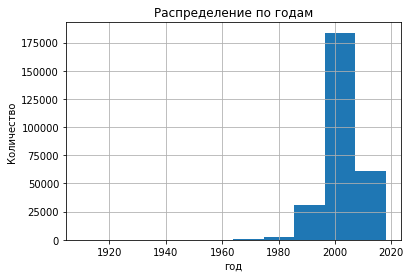

In [57]:
plt.xlabel("год")
plt.ylabel('Количество')
plt.title('Распределение по годам')
df['RegistrationYear'].hist()

С годами все норм.

In [46]:
df['Power'].describe()

count    284125.000000
mean        117.657235
std         164.942599
min           0.000000
25%          75.000000
50%         109.000000
75%         147.000000
max       19211.000000
Name: Power, dtype: float64

In [53]:
len(df.query('Power > 15000'))

12

Удалим авто с аномальной мощностью и нулевой ценой.

In [58]:
df = df.query('Power < 15000')

In [59]:
df = df.query('Price > 0')

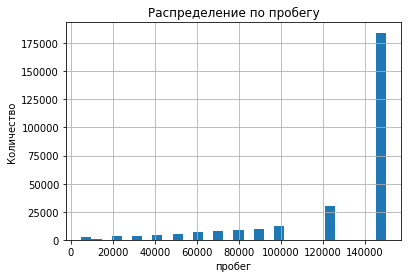

In [64]:
plt.xlabel("пробег")
plt.ylabel('Количество')
plt.title('Распределение по пробегу')
df['Kilometer'].hist(bins=30)

Выглядит правдоподобно, переходим к обработке категориальных признаков.

In [65]:
new_df = df.copy()

In [66]:
new_df = pd.get_dummies(new_df, drop_first=True)

In [67]:
new_df.sample()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NotRepaired,NumberOfPictures,VehicleType_convertible,VehicleType_coupe,VehicleType_other,...,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo
55281,3899,2006,150,150000,5,False,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Плохо, конечно, что  мновато признаков. Если не получится нориально обучить модель, попробуем порядковое кодирование.

<div class="alert alert-block alert-success">
<b>Успех (ревью 2):</b> Отлично, спасибо!
</div>

## Обучение моделей

Разобъем выборку.

In [32]:
target = new_df['Price']
features = new_df.drop('Price', 1)

In [68]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=.25, random_state=123)

In [70]:
len(features_train) / len(features_test)

2.99997184367609

Разбиение прошло корректно.

Данные разбиты на 2 выборки - обучающую и тестовую в соотношении 3:1.  
Теперь попробуем обучить линейную регрессию.

In [72]:
scorer = make_scorer(mean_squared_error, greater_is_better = False)

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> Для начала попробую простейшую модель без бустинга.
</div>

In [73]:
%%time
model = LinearRegression()
parameters = {'fit_intercept':[True,False], 
              'normalize':[True,False],
              'copy_X':[True, False]}
grid = GridSearchCV(model, param_grid=parameters, cv=5, scoring=scorer, verbose=3)
grid.fit(features_train, target_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] copy_X=True, fit_intercept=True, normalize=True .................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  copy_X=True, fit_intercept=True, normalize=True, score=-7407351.482, total=  31.6s
[CV] copy_X=True, fit_intercept=True, normalize=True .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.6s remaining:    0.0s


[CV]  copy_X=True, fit_intercept=True, normalize=True, score=-7336724.028, total=  30.5s
[CV] copy_X=True, fit_intercept=True, normalize=True .................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min remaining:    0.0s


[CV]  copy_X=True, fit_intercept=True, normalize=True, score=-876262165565754738005499355070464.000, total=  28.2s
[CV] copy_X=True, fit_intercept=True, normalize=True .................
[CV]  copy_X=True, fit_intercept=True, normalize=True, score=-1641633849066623425812847656960.000, total=  28.9s
[CV] copy_X=True, fit_intercept=True, normalize=True .................
[CV]  copy_X=True, fit_intercept=True, normalize=True, score=-7593991.515, total=  29.1s
[CV] copy_X=True, fit_intercept=True, normalize=False ................
[CV]  copy_X=True, fit_intercept=True, normalize=False, score=-7407360.099, total=  26.5s
[CV] copy_X=True, fit_intercept=True, normalize=False ................
[CV]  copy_X=True, fit_intercept=True, normalize=False, score=-7336734.158, total=  28.1s
[CV] copy_X=True, fit_intercept=True, normalize=False ................
[CV]  copy_X=True, fit_intercept=True, normalize=False, score=-7420262.085, total=  26.6s
[CV] copy_X=True, fit_intercept=True, normalize=False ....

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 18.6min finished


CPU times: user 13min 5s, sys: 5min 55s, total: 19min 1s
Wall time: 19min 6s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='warn', n_jobs=None,
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mean_squared_error, greater_is_better=False),
             verbose=3)

In [74]:
grid.best_params_

{'copy_X': True, 'fit_intercept': True, 'normalize': False}

In [84]:
models_compare = pd.DataFrame(index=['Linear_Regression', 'Boosting'], columns=['train_time', 'forecast_time', 'RMSE'])

In [95]:
models_compare.loc['Linear_Regression', 'train_time'] = '19min 6s'

In [102]:
models_compare.loc['Linear_Regression', 'RMSE'] = (-grid.best_score_)**.5

In [103]:
%%time
grid.predict(features_test)

CPU times: user 1.14 s, sys: 387 ms, total: 1.53 s
Wall time: 1.47 s


array([12990.87092243,   848.61964549,  8591.36967658, ...,
        9009.45637436, 10058.75889561,  3542.4730925 ])

In [104]:
models_compare.loc['Linear_Regression', 'forecast_time'] = '1.46 s'

In [105]:
models_compare.head()

,train_time,forecast_time,RMSE
Linear_Regression,19min 6s,1.46 s,2733.02
Boosting,NaN,NaN,NaN


In [43]:
#features_test%%time
#model = RandomForestRegressor(random_state=12)
#parameters = {'n_estimators': range (20, 31, 10),
#              'max_depth': range (4,8, 3)}
#grid = GridSearchCV(model, param_grid=parameters, cv=5, scoring=scorer, verbose=3)
#grid.fit(features_train, target_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] max_depth=4, n_estimators=20 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . max_depth=4, n_estimators=20, score=-6460681.190, total=   5.8s
[CV] max_depth=4, n_estimators=20 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s


[CV] . max_depth=4, n_estimators=20, score=-6374519.434, total=   4.8s
[CV] max_depth=4, n_estimators=20 ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s


[CV] . max_depth=4, n_estimators=20, score=-6343928.089, total=   5.6s
[CV] max_depth=4, n_estimators=20 ....................................
[CV] . max_depth=4, n_estimators=20, score=-6421225.545, total=   6.3s
[CV] max_depth=4, n_estimators=20 ....................................
[CV] . max_depth=4, n_estimators=20, score=-6394016.898, total=   7.3s
[CV] max_depth=4, n_estimators=30 ....................................
[CV] . max_depth=4, n_estimators=30, score=-6453233.088, total=   7.1s
[CV] max_depth=4, n_estimators=30 ....................................
[CV] . max_depth=4, n_estimators=30, score=-6367692.324, total=   7.1s
[CV] max_depth=4, n_estimators=30 ....................................
[CV] . max_depth=4, n_estimators=30, score=-6341407.844, total=   6.9s
[CV] max_depth=4, n_estimators=30 ....................................
[CV] . max_depth=4, n_estimators=30, score=-6436425.912, total=   6.7s
[CV] max_depth=4, n_estimators=30 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.8min finished


CPU times: user 2min 55s, sys: 2.52 s, total: 2min 58s
Wall time: 2min 59s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=12,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': range(4, 8, 3),
    

In [44]:
grid.best_params_

{'max_depth': 7, 'n_estimators': 30}

In [48]:
(-grid.best_score_)**.5

2173.175565547217

Метрика RMSE равна 2173 - многовато.. 

Ошибка все равно большая. Пробуем градиентный бустинг.

## Анализ моделей

In [126]:
categorical_feature = ['VehicleType', 'Gearbox', 'Model','FuelType', 'Brand']

In [141]:
df[categorical_feature] = df[categorical_feature].astype('category')

In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279072 entries, 2 to 354368
Data columns (total 12 columns):
Price                279072 non-null int64
VehicleType          279072 non-null category
RegistrationYear     279072 non-null int64
Gearbox              279072 non-null category
Power                279072 non-null int64
Model                279072 non-null category
Kilometer            279072 non-null int64
RegistrationMonth    279072 non-null int64
FuelType             279072 non-null category
Brand                279072 non-null category
NotRepaired          279072 non-null bool
NumberOfPictures     279072 non-null int64
dtypes: bool(1), category(5), int64(6)
memory usage: 16.8 MB


In [143]:
target = df['Price']
features = df.drop('Price', 1)

In [144]:

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=.25, random_state=123)


In [146]:
model = LGBMRegressor(categorical_feature=categorical_feature)

In [147]:
%%time
model.fit(features_train, target_train)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:842: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:863: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


CPU times: user 8min 36s, sys: 1.76 s, total: 8min 37s
Wall time: 8min 41s


LGBMRegressor(boosting_type='gbdt',
              categorical_feature=['VehicleType', 'Gearbox', 'Model',
                                   'FuelType', 'Brand'],
              class_weight=None, colsample_bytree=1.0, importance_type='split',
              learning_rate=0.1, max_depth=-1, min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_leaves=31, objective=None, random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [150]:
%%time
predictions = model.predict(features_test)

CPU times: user 1.14 s, sys: 0 ns, total: 1.14 s
Wall time: 1.09 s


In [151]:
mean_squared_error(predictions, target_test)**.5

1588.5938209946992

Ура! СКО значительно меньше получилось. Проверим на тестовой выборке.

In [157]:
models_compare.loc['Boosting', 'forecast_time'] = '1.09 s'

In [160]:
models_compare.loc['Boosting', 'train_time'] = '8min 41s'

In [161]:
models_compare.loc['Boosting', 'RMSE'] = mean_squared_error(predictions, target_test)**.5

In [162]:
models_compare.head()

,train_time,forecast_time,RMSE
Linear_Regression,19min 6s,1.46 s,2733.02
Boosting,8min 41s,1.09 s,1588.59


In [ ]:
Тоже неплохой результат. Посмотрим на целевой признак.

In [152]:
df['Price'].describe()

count    279072.000000
mean       4934.779068
std        4632.375799
min           1.000000
25%        1400.000000
50%        3259.500000
75%        7000.000000
max       20000.000000
Name: Price, dtype: float64

In [154]:
predictions = pd.Series(predictions)

In [155]:
predictions.describe()

count    69768.000000
mean      4936.132978
std       4329.515361
min       -564.071476
25%       1502.134125
50%       3391.446439
75%       7152.728348
max      19626.257054
dtype: float64

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


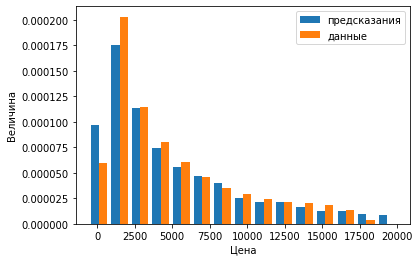

In [156]:
plt.xlabel("Цена")
plt.ylabel('Величина')
plt.hist([new_df['Price'], predictions], label= ['предсказания', 'данные'], bins=15, density=True)
plt.legend(loc='upper right')
plt.show()


На графике хорошо видно, что модель неплохо прогнозирует стоимость авто. Есть, конечно, неточности (отрицательные значения), но меня таким не удивишь) 